In [15]:
from IPython.display import display, Math, Latex
from skimage import transform
from skimage import io 
from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
from torch.optim import lr_scheduler


plt.ion()   # interactive mode

### Connect to Google Colab for GPU support

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data:  images and labels

In [25]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    
    labels = []
    images = []
    for i, d in enumerate(directories):
        print(f'{i}/{len(d)}')
        # Tell computer where to look for the files
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".ppm")]
          # Open the files
        for i, f in enumerate(file_names):
            print(f'{i}/{len(file_names)}')
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels

In [ ]:
ROOT_PATH = "/content/drive/My Drive/Colab Notebooks/Traffic_Signs"
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_directory)

In [ ]:
image_array = np.array(images)
label_array = np.array(labels)
image_array.shape
label_array.shape
print("There are ", image_array.shape, " pictures in your dataset of different sizes each")
print("There are ", label_array.shape, " labels in your dataset")

### Display a few sample images

shape: (105, 83, 3), min: 5, max: 255
shape: (154, 109, 3), min: 0, max: 255
shape: (100, 107, 3), min: 9, max: 255
shape: (93, 85, 3), min: 3, max: 218


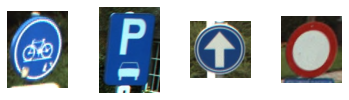

In [ ]:
sample_signs = [300, 2250, 3650, 4000]

for i in range(len(sample_signs)):
    plt.subplot(1, 4, i+1)   # 1x4 display
    plt.axis("off")
    plt.imshow(images[sample_signs[i]])
    plt.subplots_adjust(wspace = 0.5)
    print("shape: {0}, min: {1}, max: {2}".format(images[sample_signs[i]].shape, 
                                                  images[sample_signs[i]].min(),
                                                  images[sample_signs[i]].max()))

plt.show()

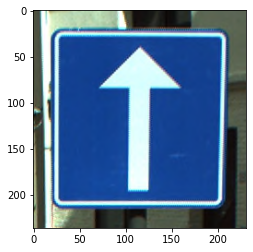

In [ ]:
plt.imshow(images[666])
plt.show()

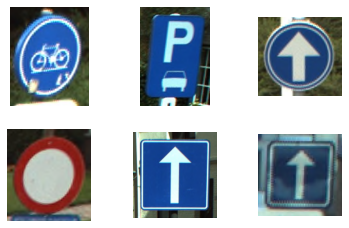

In [ ]:
more_sample_signs = [300, 2250, 3650, 4000, 666, 777]

for i in range(len(more_sample_signs)):
    plt.subplot(2, 3, i+1)   # 2x3 subplot display 
    plt.axis("off")
    plt.imshow(images[more_sample_signs[i]])
    plt.subplots_adjust(wspace = 0.5)

plt.show()

## Distribution of labels across the dataset

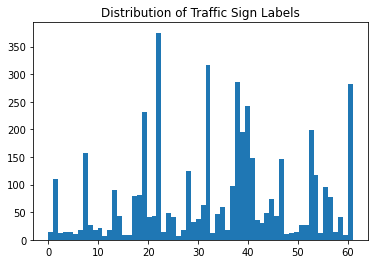

In [ ]:
plt.hist(labels, 62)
plt.title("Distribution of Traffic Sign Labels")
plt.show()

### Display each Class in dataset with associated image

In [ ]:
# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[labels.index(label)]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, labels.count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)

## Loading and Transforming Images with PyTorch

In [5]:
data_transforms = {
    'Training': transforms.Compose([
        #transforms.RandomResizedCrop(224),            # <---- Randomly crop a section of an image into a 224x224 crop
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),            # <-- Flip to augment training data so it generalizes better
        transforms.ToTensor(),                         # <--- Transform image data into PyTorch Tensor object
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),                         # ^ --- These are the mean & std of the pixel intensities in the 3 RGB channels
    'Testing': transforms.Compose([
        transforms.Resize(256),   
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
}

In [6]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Traffic_Signs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Display a few images after Transformations

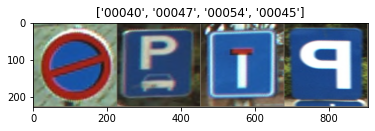

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## FineTune the Model (ResNet18) via Transfer Learning

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    torch.save(model.state_dict(), data_dir+'/sign.pth')  # Save Model weights to directory

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Setup for Prediction Visualization

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Train the Model

In [7]:
model_ft = models.resnet18(pretrained=True)  # Load in ResNet18 and store their pretrained weights
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 62.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 62)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Training Loss: 1.0132 Acc: 0.7823
Testing Loss: 0.2286 Acc: 0.9433

Epoch 1/9
----------
Training Loss: 0.1834 Acc: 0.9637
Testing Loss: 0.1510 Acc: 0.9575

Epoch 2/9
----------
Training Loss: 0.0976 Acc: 0.9821
Testing Loss: 0.1290 Acc: 0.9659

Epoch 3/9
----------
Training Loss: 0.0600 Acc: 0.9902
Testing Loss: 0.1604 Acc: 0.9575

Epoch 4/9
----------
Training Loss: 0.0373 Acc: 0.9932
Testing Loss: 0.1311 Acc: 0.9651

Epoch 5/9
----------
Training Loss: 0.0358 Acc: 0.9943
Testing Loss: 0.1253 Acc: 0.9679

Epoch 6/9
----------
Training Loss: 0.0223 Acc: 0.9963
Testing Loss: 0.1336 Acc: 0.9679

Epoch 7/9
----------
Training Loss: 0.0186 Acc: 0.9980
Testing Loss: 0.1197 Acc: 0.9738

Epoch 8/9
----------
Training Loss: 0.0167 Acc: 0.9980
Testing Loss: 0.1128 Acc: 0.9734

Epoch 9/9
----------
Training Loss: 0.0159 Acc: 0.9989
Testing Loss: 0.1190 Acc: 0.9690

Training complete in 12m 38s
Best val Acc: 0.973810


## Visualize some Predictions

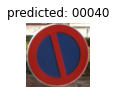

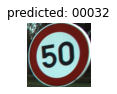

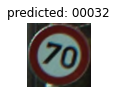

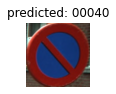

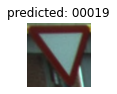

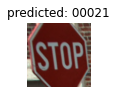

In [12]:
model_ft.load_state_dict(torch.load(data_dir+'/sign.pth')) 
visualize_model(model_ft)

plt.ioff()
plt.show()

## Run Model on Testing data

In [20]:
def test_model(model, test_loader):
    model.load_state_dict(torch.load(data_dir+'/sign.pth')) 
    model.cuda()
    model.eval()

    predictions = []
    trues = []

    for inputs, targets in test_loader:
        pred = model(inputs.cuda()).data.cuda().cpu().numpy().copy()
        true = targets.numpy().copy()

        predictions.append(pred)
        trues.append(true)
    return np.concatenate(predictions), np.concatenate(trues)

In [22]:
preds_test, y_true = test_model(model_ft, dataloaders['Testing'])

### Construct Confusion Matrix for all Classes

In [46]:
def display_confusion_matrix(y_true, preds, unique_labels, annot, figsize=(9,7), fontsize=14):
    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
    np.set_printoptions(precision=2)

    title_str = f'Confusion Matrix: Acc: {acc:0.3f}, F1: {score:0.3f}'

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title_str)
    plt.show()

In [41]:
unique_labels = list(map(str, list(range(0,54))))

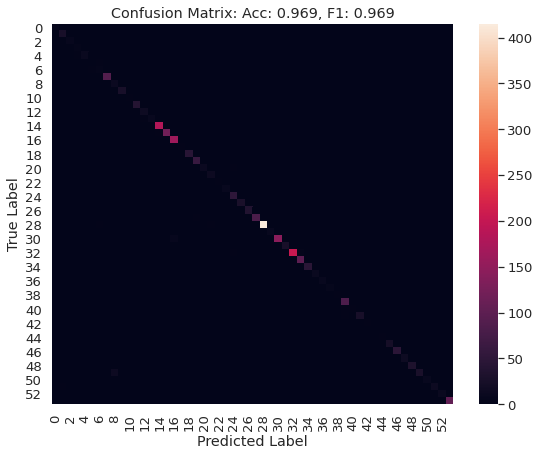

In [49]:
display_confusion_matrix(y_true, preds_test, unique_labels, annot=False, figsize=(9,7), fontsize=14)

## Print out Classification Report

In [48]:
print(classification_report(y_true, preds_test.argmax(1), target_names=unique_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.90      1.00      0.95        27
           2       1.00      1.00      1.00         7
           3       0.67      0.67      0.67         6
           4       0.91      0.83      0.87        12
           5       0.00      0.00      0.00         3
           6       0.44      0.67      0.53         6
           7       1.00      1.00      1.00        90
           8       0.48      1.00      0.65        12
           9       1.00      0.96      0.98        28
          10       1.00      1.00      1.00         3
          11       0.97      1.00      0.99        39
          12       0.83      1.00      0.91        15
          13       0.90      0.75      0.82        12
          14       0.98      1.00      0.99       183
          15       1.00      0.98      0.99       122
          16       0.95      1.00      0.97       163
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
